In [1]:
import io
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [13]:
aaa = np.load('/root/real2sim/sim2sim/output/Table-v1/2023-04-02 11:30:39.526783/parameters.npy')

In [11]:
aaa_list = []
for a in aaa:
    aaa_list.append(a[0])

In [14]:
aaa

array([[0.1       ],
       [0.2       ],
       [0.30003811],
       [0.40006022],
       [0.50006664],
       [0.60010591],
       [0.70029143],
       [0.80020658],
       [0.89914346],
       [0.99618073],
       [1.09144315],
       [1.18505675],
       [1.27685933],
       [1.36732609],
       [1.45446351],
       [1.53361406],
       [1.60364137],
       [1.65928295],
       [1.69986406],
       [1.73241317],
       [1.68799673],
       [1.6441157 ],
       [1.60282311],
       [1.56385233],
       [1.52671844],
       [1.49271379],
       [1.46191233],
       [1.43387215],
       [1.40857744],
       [1.38589773],
       [1.36599077],
       [1.34916323],
       [1.33573425],
       [1.32543554],
       [1.31787169],
       [1.31283571],
       [1.30996824],
       [1.30910446],
       [1.31004588],
       [1.3126894 ],
       [1.31687406],
       [1.32258506],
       [1.32978621],
       [1.33845517],
       [1.34862315],
       [1.36002653],
       [1.37212074],
       [1.384

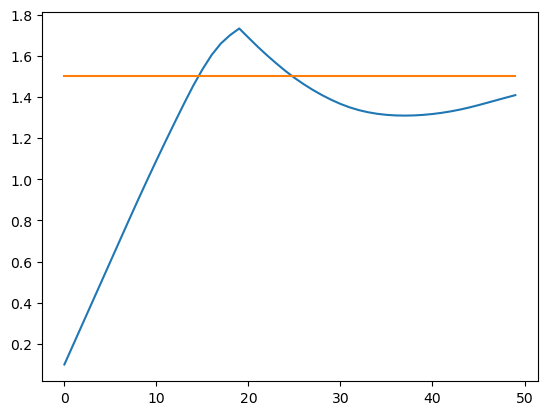

In [12]:
plt.plot(aaa_list)
plt.plot([1.5]*len(aaa_list))